In [2]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")
from stepwise_util import default_stepwise_candidate_predictors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# https://stackoverflow.com/questions/43147983/could-not-create-cudnn-handle-cudnn-status-internal-error
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
target = "contest_tmp2m" # "contest_precip" or "contest_tmp2m"
target_horizon = "34w" # "34w" or "56w"

data_path = os.path.expanduser("forecast_rodeo/results/regression/shared")
data_matrices_folder = f"{target}_{target_horizon}"
fs = glob.glob(f"{data_path}/{data_matrices_folder}/*.h5")
print(fs)
lat_lon_date_data_file = fs[0]
date_data_file = fs[1]

['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']


## Define dates of interest for prediction

In [5]:
# some vars
gt_col = target.split('_')[-1]  # 'tmp2m'
clim_col = f"{gt_col}_clim"     # 'tmp2m_clim'
anom_col = f"{gt_col}_anom"     # 'tmp2m_anom'
group_by_cols = ['lat', 'lon']
first_train_year = 1978 # use 1948 for precip, 1978 for temp
start_delta = 29 # 29 for 34w or 43 for 56w

# get data array names we care about
candidate_x_cols = default_stepwise_candidate_predictors(target, target_horizon, hindcast=False)

relevant_cols = set(candidate_x_cols
                    +[clim_col,anom_col,'start_date','lat','lon','target','year']#,'ones']
                    +group_by_cols)
relevant_cols.remove('ones')
candidate_x_cols.remove('ones')
print(relevant_cols)
print(candidate_x_cols)
for c in relevant_cols:
    if c not in candidate_x_cols:
        print(c)

{'nmme0_wo_ccsm3_nasa', 'lat', 'tmp2m_clim', 'tmp2m_shift58_anom', 'tmp2m_shift58', 'phase_shift17', 'start_date', 'icec_2010_3_shift30', 'icec_2010_2_shift30', 'target', 'rhum_shift30', 'sst_2010_2_shift30', 'sst_2010_3_shift30', 'wind_hgt_10_2010_2_shift30', 'wind_hgt_10_2010_1_shift30', 'lon', 'mei_shift45', 'tmp2m_shift29', 'tmp2m_anom', 'year', 'pres_shift30', 'sst_2010_1_shift30', 'nmme_wo_ccsm3_nasa', 'icec_2010_1_shift30', 'tmp2m_shift29_anom'}
['tmp2m_shift29', 'tmp2m_shift29_anom', 'tmp2m_shift58', 'tmp2m_shift58_anom', 'rhum_shift30', 'pres_shift30', 'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa', 'mei_shift45', 'phase_shift17', 'sst_2010_1_shift30', 'sst_2010_2_shift30', 'sst_2010_3_shift30', 'icec_2010_1_shift30', 'icec_2010_2_shift30', 'icec_2010_3_shift30', 'wind_hgt_10_2010_1_shift30', 'wind_hgt_10_2010_2_shift30']
lat
tmp2m_clim
start_date
target
lon
tmp2m_anom
year


## Load the data files

In [6]:
# raw data files
date_data = pd.read_hdf(date_data_file)
lat_lon_date_data = pd.read_hdf(lat_lon_date_data_file)

In [7]:
# filter out data older than "first_train_year" and keep only relevant columns
data = lat_lon_date_data.loc[lat_lon_date_data.start_date.dt.year >= first_train_year,
                             lat_lon_date_data.columns.isin(relevant_cols)]
data = pd.merge(data, date_data.loc[date_data.start_date.dt.year >= first_train_year,
                                    date_data.columns.isin(relevant_cols)],
                on="start_date", how="left")
del lat_lon_date_data
del date_data

print(len(data.columns))
print(data.columns)

23
Index(['lat', 'lon', 'start_date', 'rhum_shift30', 'pres_shift30',
       'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa', 'tmp2m_clim', 'tmp2m_anom',
       'tmp2m_shift29', 'tmp2m_shift29_anom', 'tmp2m_shift58',
       'tmp2m_shift58_anom', 'mei_shift45', 'phase_shift17',
       'sst_2010_1_shift30', 'sst_2010_2_shift30', 'sst_2010_3_shift30',
       'icec_2010_1_shift30', 'icec_2010_2_shift30', 'icec_2010_3_shift30',
       'wind_hgt_10_2010_1_shift30', 'wind_hgt_10_2010_2_shift30'],
      dtype='object')


In [8]:
data['year'] = data.start_date.dt.year

In [9]:
# this is really tmp2m_clim + tmp2m_anom
data['target'] = data[clim_col] + data[anom_col]

# drop data that doesn't have valid targets
data_valid_targets = data.dropna(subset=candidate_x_cols+['target'])

In [10]:
print(data_valid_targets.head())
print(data_valid_targets)

       lat    lon start_date  rhum_shift30  pres_shift30  nmme_wo_ccsm3_nasa  \
1096  27.0  261.0 1982-01-01     70.420459  99167.996512           12.467787   
1097  27.0  261.0 1982-01-02     72.955266  99165.462333           12.467787   
1098  27.0  261.0 1982-01-03     74.292511  99175.210100           12.467787   
1099  27.0  261.0 1982-01-04     73.203110  99199.950614           12.467787   
1100  27.0  261.0 1982-01-05     73.615885  99200.662667           12.467787   

      nmme0_wo_ccsm3_nasa  tmp2m_clim  tmp2m_anom  tmp2m_shift29  ...  \
1096            14.397082   13.877076   -2.529009      17.393454  ...   
1097            14.397082   13.817056   -2.386775      16.864281  ...   
1098            14.397082   13.872171   -2.898529      16.131157  ...   
1099            14.397082   13.829688   -3.939882      15.877757  ...   
1100            14.397082   13.792283   -3.644579      16.066349  ...   

      sst_2010_1_shift30  sst_2010_2_shift30  sst_2010_3_shift30  \
1096        

In [11]:
data_grouped_by_latlon = data_valid_targets.loc[:,relevant_cols].groupby(group_by_cols)

In [12]:
# for latlon, group in data_grouped_by_latlon:
#     print(latlon)

latlons = [latlon for latlon, _ in data_grouped_by_latlon]
lat_oi, lon_oi = latlons[0] #(37.0, 238.0)

data_at_lat_lon = data_grouped_by_latlon.get_group((lat_oi, lon_oi))
print(f"lat_oi: {lat_oi}, lon_oi: {lon_oi}")

lat_oi: 27.0, lon_oi: 261.0


## Modelling
We want to predict the temperature `tmp2m` (stored in `target`) using features from the list `candidate_x_cols` using training data in the past

In [13]:
Y = data_at_lat_lon['target']
X = data_at_lat_lon[candidate_x_cols]
dates = data_at_lat_lon['start_date']

years_in_data = dates.dt.year
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)
print(X.columns)

num_forecast_steps = 7 * 4 # 28 days

Xnp = X.to_numpy().astype(np.float32)
Ynp = Y.to_numpy().astype(np.float32)

Y_train = Ynp[:-num_forecast_steps]
X_train = Xnp[:-num_forecast_steps, :]
dates_train = dates[:-num_forecast_steps]

Y_test = Ynp[-num_forecast_steps:]
X_test = Xnp[-num_forecast_steps:, :]
dates_test = dates[-num_forecast_steps:]

columnstr_to_index = {key: idx for idx, key in enumerate(X.columns)}
index_to_columnstr = {idx: key for idx, key in enumerate(X.columns)}

1982
2018
Index(['tmp2m_shift29', 'tmp2m_shift29_anom', 'tmp2m_shift58',
       'tmp2m_shift58_anom', 'rhum_shift30', 'pres_shift30',
       'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa', 'mei_shift45',
       'phase_shift17', 'sst_2010_1_shift30', 'sst_2010_2_shift30',
       'sst_2010_3_shift30', 'icec_2010_1_shift30', 'icec_2010_2_shift30',
       'icec_2010_3_shift30', 'wind_hgt_10_2010_1_shift30',
       'wind_hgt_10_2010_2_shift30'],
      dtype='object')


(13255,)


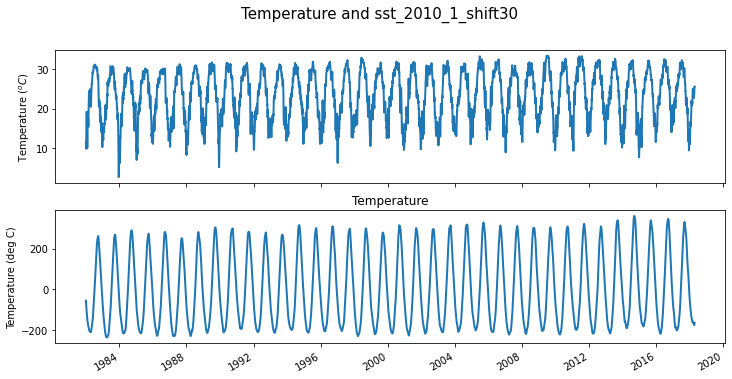

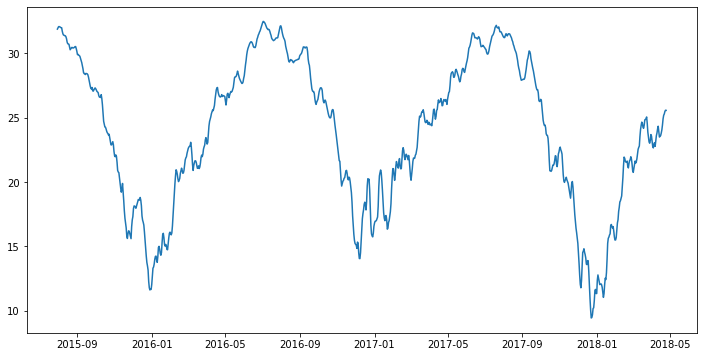

In [14]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

ax.plot(dates_train,
        X_train[:, columnstr_to_index['sst_2010_1_shift30']], lw=2, label="training data")
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")
fig.suptitle(f"Temperature and sst_2010_1_shift30",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [15]:
print(X_train.shape)
def build_model(observed_time_series):
    seasonal = tfp.sts.Seasonal(
        num_seasons=4, 
        observed_time_series=observed_time_series,
        num_steps_per_season=91, 
        name='seasonal'
    )
    monthly = tfp.sts.Seasonal(
        num_seasons=12,
        observed_time_series=observed_time_series,
        num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
        initial_effect_prior=tfd.Normal(loc=0., scale=5.),
        name='month_of_year',
    )
#     features_effect = tfp.sts.LinearRegression(
#         design_matrix=other_features - np.mean(other_features), 
#         name='other_fehthhhhhhhhhhhatures'
#     )   
    autoregressive = tfp.sts.Autoregressive(
        order=1,
        observed_time_series=observed_time_series,
        name='autoregressive'
    )
    model = tfp.sts.Sum([
            seasonal,
            monthly,
#             features_effect,
            autoregressive
        ],
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)

(13255, 18)
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


100
877.7076811790466 seconds


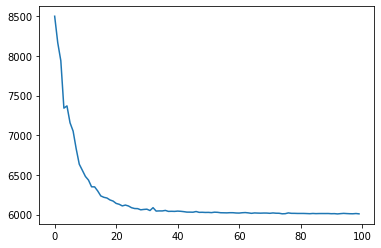

In [18]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 100
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [20]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.015600493177771568 +- 0.00047961040399968624
seasonal/_drift_scale: 0.011076666414737701 +- 0.014572016894817352
month_of_year/_drift_scale: 0.1950501948595047 +- 0.014584869146347046
autoregressive/_coefficients: [0.9978049] +- [0.00057984]
autoregressive/_level_scale: 0.38169461488723755 +- 0.002708525862544775


## Forecasting

In [22]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train,
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

In [30]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None, plot_num=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    if plot_num is not None:
        x = x[-plot_num:]
        y = y[-plot_num:]

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast

    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = x[num_steps_train:]

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

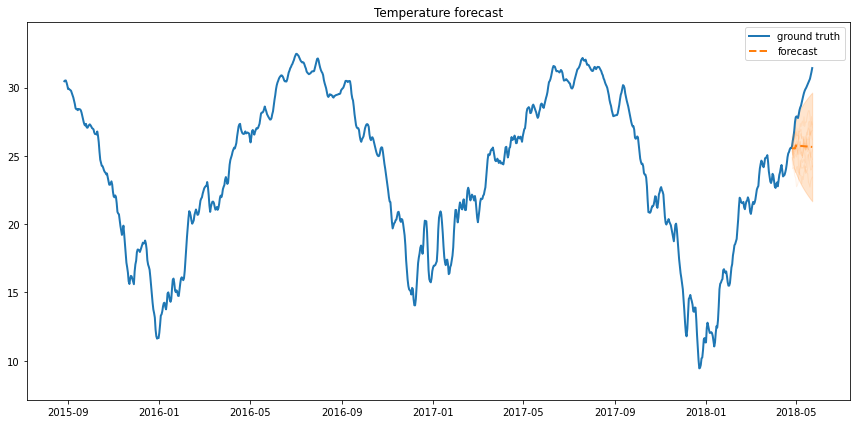

In [32]:
num_samples=10

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

fig, ax = plot_forecast(dates, Ynp,
                        temperature_forecast_mean,
                        temperature_forecast_scale,
                        temperature_forecast_samples,
                        title="Temperature forecast",
                        plot_num=1000,
)
fig.tight_layout()
